In [1]:
# Import Modules #

import os
import gc
import time
import random
from datetime import datetime

import torch
import torch.nn.functional as F
from torch import rand
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler

import torchvision.utils as vutils
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import wandb
import psutil
import lpips

from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel

### Model Definition ###

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pretrained CelebA DDPM model
pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")

# Access the UNet model from the pipeline
model = pipeline.unet
model = model.to(device)  # Move the model to GPU if available

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


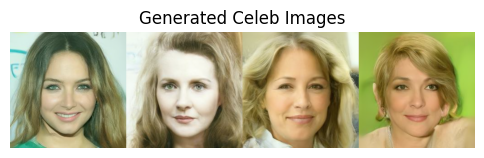

In [3]:
@torch.no_grad()
def sample(model, scheduler, num_images=4, batch_size=4):
    model.eval()
    all_images = []

    num_batches = (num_images + batch_size - 1) // batch_size  # ceiling division

    for i in range(num_batches):
        current_batch_size = min(batch_size, num_images - i * batch_size)
        images = torch.randn((current_batch_size, 3, 256, 256)).to(device)
        scheduler.set_timesteps(100)

        for t in scheduler.timesteps:
            noise_pred = model(images, t).sample
            images = scheduler.step(noise_pred, t, images).prev_sample

        all_images.append(images.cpu())

    return torch.cat(all_images, dim=0)[:num_images]

samples = sample(model, scheduler, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # from [-1, 1] to [0, 1]

grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(6, 3))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated Celeb Images") 
plt.show()

### The Anime Dataset ###

In [4]:
# Define dataset class for loading images
class AnimeDataset(Dataset):
    def __init__(self, root_dir, transform=None, limit=2000):
        self.root_dir = root_dir
        # Get all image files and shuffle them randomly
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(self.image_files)  # Shuffle the image list
        self.image_files = self.image_files[:limit]  # Limit to the first 'limit' images
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels
        if self.transform:
            image = self.transform(image)
        return image

### Section A: Improved DataLoading ###

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),          
    transforms.Normalize((0.5,), (0.5,))  
])

# Load the dataset with a limit of 1000 random images
dataset = AnimeDataset(root_dir="data/images", transform=transform, limit=2000)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
NUM_RUNS = 5

epoch_times = []
avg_batch_times = []
max_batch_times = []
min_batch_times = []
avg_cpu_usages = []
peak_cpu_usages = []

for _ in range(NUM_RUNS):
    batch_times = []
    cpu_usages = []
    process = psutil.Process()
    start_epoch = time.time()

    for batch in dataloader:
        batch_start = time.time()
        batch = batch.to(device)
        torch.cuda.synchronize()
        batch_end = time.time()
        batch_times.append(batch_end - batch_start)
        cpu_usages.append(process.cpu_percent(interval=0.01))

    end_epoch = time.time()
    epoch_times.append(end_epoch - start_epoch)
    avg_batch_times.append(sum(batch_times) / len(batch_times))
    max_batch_times.append(max(batch_times))
    min_batch_times.append(min(batch_times))
    avg_cpu_usages.append(sum(cpu_usages) / len(cpu_usages))
    peak_cpu_usages.append(max(cpu_usages))

print("=== Average over 5 runs ===")
print(f"Average epoch time: {sum(epoch_times)/NUM_RUNS:.3f} seconds")
print(f"Average batch time: {sum(avg_batch_times)/NUM_RUNS:.4f} seconds")
print(f"Average max batch time: {sum(max_batch_times)/NUM_RUNS:.4f} seconds")
print(f"Average min batch time: {sum(min_batch_times)/NUM_RUNS:.4f} seconds")
print(f"Average CPU usage: {sum(avg_cpu_usages)/NUM_RUNS:.2f}%")
print(f"Average peak CPU usage: {sum(peak_cpu_usages)/NUM_RUNS:.2f}%")

=== Average over 5 runs ===
Average epoch time: 4.945 seconds
Average batch time: 0.0029 seconds
Average max batch time: 0.0031 seconds
Average min batch time: 0.0028 seconds
Average CPU usage: 303.46%
Average peak CPU usage: 393.88%


In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),         
    transforms.Normalize((0.5,), (0.5,)) 
])

# Load dataset
dataset = AnimeDataset(root_dir="data/images", transform=transform, limit=2000)
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,           # Adjust based on CPU cores
    pin_memory=True,         # Speeds up transfer to GPU
    prefetch_factor=2,       # Number of batches per worker to prefetch
    persistent_workers=True  # Keeps workers alive between epochs
)

In [8]:
epoch_times = []
avg_batch_times = []
max_batch_times = []
min_batch_times = []
avg_cpu_usages = []
peak_cpu_usages = []

for _ in range(NUM_RUNS):
    batch_times = []
    cpu_usages = []
    process = psutil.Process()
    start_epoch = time.time()

    for batch in dataloader:
        batch_start = time.time()
        batch = batch.to(device, non_blocking=True)
        torch.cuda.synchronize()
        batch_end = time.time()
        batch_times.append(batch_end - batch_start)
        cpu_usages.append(process.cpu_percent(interval=0.01))

    end_epoch = time.time()
    epoch_times.append(end_epoch - start_epoch)
    avg_batch_times.append(sum(batch_times) / len(batch_times))
    max_batch_times.append(max(batch_times))
    min_batch_times.append(min(batch_times))
    avg_cpu_usages.append(sum(cpu_usages) / len(cpu_usages))
    peak_cpu_usages.append(max(cpu_usages))

print("=== Average over 5 runs ===")
print(f"Average epoch time: {sum(epoch_times)/NUM_RUNS:.3f} seconds")
print(f"Average batch time: {sum(avg_batch_times)/NUM_RUNS:.4f} seconds")
print(f"Average max batch time: {sum(max_batch_times)/NUM_RUNS:.4f} seconds")
print(f"Average min batch time: {sum(min_batch_times)/NUM_RUNS:.4f} seconds")
print(f"Average CPU usage: {sum(avg_cpu_usages)/NUM_RUNS:.2f}%")
print(f"Average peak CPU usage: {sum(peak_cpu_usages)/NUM_RUNS:.2f}%")

=== Average over 5 runs ===
Average epoch time: 1.781 seconds
Average batch time: 0.0014 seconds
Average max batch time: 0.0043 seconds
Average min batch time: 0.0013 seconds
Average CPU usage: 49.38%
Average peak CPU usage: 196.62%


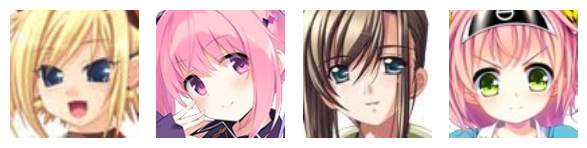

In [9]:
def unnormalize(img):
    img = img / 2 + 0.5  
    return img

# Visualize a batch of images
def visualize_batch(dataloader):
    images = next(iter(dataloader))
    images = unnormalize(images).permute(0, 2, 3, 1).numpy()  

    # Create a grid to display the images
    plt.figure(figsize=(6, 3))  
    for i in range(4):  
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i], interpolation='nearest') 
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_batch(dataloader)

### Section B: Finetuning Model on the Anime Dataset (Resolution: 256x256) ###

In [10]:
def log_epoch_stats(epoch, avg_loss, avg_step_time, total_epoch_time, avg_cuda_alloc, avg_cuda_reserved, avg_cpu_mem):
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Avg Loss:           {avg_loss:.6f}")
    print(f"  Avg Step Time:      {avg_step_time:.4f} sec")
    print(f"  Total Epoch Time:   {total_epoch_time:.2f} sec")
    print(f"  Avg CUDA Alloc:     {avg_cuda_alloc:.2f} MB")
    print(f"  Avg CUDA Reserved:  {avg_cuda_reserved:.2f} MB")
    print(f"  Avg CPU Mem:        {avg_cpu_mem:.2f} MB\n")

    wandb.log({
        "epoch": epoch + 1,
        "epoch_avg_loss": avg_loss,
        "epoch_avg_step_time_sec": avg_step_time,
        "epoch_total_time_sec": total_epoch_time,
        "epoch_avg_cuda_alloc_MB": avg_cuda_alloc,
        "epoch_avg_cuda_reserved_MB": avg_cuda_reserved,
        "epoch_avg_cpu_mem_MB": avg_cpu_mem,
    })

In [11]:
def clean_basic():
    """
    Delete common variables and free unused GPU/CPU memory.
    """
    for name in [
        'pipeline',
        'optimizer',
        'images', 'timesteps', 'noise', 'noisy_images', 'noise_pred', 'loss'
    ]:
        try:
            del globals()[name]
        except:
            pass

    gc.collect()
    torch.cuda.empty_cache()

# Usage:
clean_basic()

In [12]:
number_of_training_images = 2000
dataset = AnimeDataset(root_dir="data/images", transform=transform, limit=number_of_training_images)
dataloader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,           #
    pin_memory=True,         # Speeds up transfer to GPU
    prefetch_factor=2,       # Number of batches per worker to prefetch
    persistent_workers=True  # Keeps workers alive between epochs
)

In [13]:
# Load the pretrained CelebA DDPM model
pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
baseline_model = pipeline.unet
baseline_model = model.to(device)  # Move the model to GPU if available

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [14]:
wandb.init(
    project="DDPM_Project",          
    name="experiment_baseline_256",             
    config={
        "epochs": 5,
        "lr": 1e-4,
        "batch_size": dataloader.batch_size,
        "scheduler": scheduler.config,
        "model": str(baseline_model.__class__.__name__),
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yc4528 (yc4528-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [15]:
optimizer = Adam(baseline_model.parameters(), lr=wandb.config.lr)
baseline_model.train()
num_epochs = wandb.config.epochs

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0.0
    epoch_steps = 0
    epoch_step_times = []
    epoch_cuda_alloc = []
    epoch_cuda_reserved = []
    epoch_cpu_mem = []
    optimizer.zero_grad()

    for step, images in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        step_start = time.time()
        images = images.to("cuda")  

        batch_size = images.size(0)
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device="cuda").long()
        noise = torch.randn_like(images)
        noisy_images = scheduler.add_noise(images, noise, timesteps)

        # Forward pass
        noise_pred = baseline_model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record stats
        epoch_loss += loss.item()
        epoch_steps += 1
        epoch_step_times.append(time.time() - step_start)
        epoch_cuda_alloc.append(torch.cuda.memory_allocated() / (1024 ** 2))
        epoch_cuda_reserved.append(torch.cuda.memory_reserved() / (1024 ** 2))
        epoch_cpu_mem.append(psutil.Process().memory_info().rss / (1024 ** 2))

    avg_loss = epoch_loss / epoch_steps
    avg_step_time = sum(epoch_step_times) / epoch_steps
    total_epoch_time = time.time() - epoch_start
    avg_cuda_alloc = sum(epoch_cuda_alloc) / epoch_steps
    avg_cuda_reserved = sum(epoch_cuda_reserved) / epoch_steps
    avg_cpu_mem = sum(epoch_cpu_mem) / epoch_steps

    log_epoch_stats(
        epoch,
        avg_loss,
        avg_step_time,
        total_epoch_time,
        avg_cuda_alloc,
        avg_cuda_reserved,
        avg_cpu_mem
    )

wandb.finish()

Epoch 1/5:   0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/5: 100%|██████████| 1000/1000 [11:39<00:00,  1.43it/s]



Epoch 1 Summary:
  Avg Loss:           0.011711
  Avg Step Time:      0.6963 sec
  Total Epoch Time:   699.29 sec
  Avg CUDA Alloc:     1804.53 MB
  Avg CUDA Reserved:  7204.69 MB
  Avg CPU Mem:        1630.74 MB



Epoch 2/5: 100%|██████████| 1000/1000 [11:38<00:00,  1.43it/s]



Epoch 2 Summary:
  Avg Loss:           0.010464
  Avg Step Time:      0.6955 sec
  Total Epoch Time:   698.33 sec
  Avg CUDA Alloc:     1803.87 MB
  Avg CUDA Reserved:  7206.00 MB
  Avg CPU Mem:        1635.45 MB



Epoch 3/5: 100%|██████████| 1000/1000 [11:38<00:00,  1.43it/s]



Epoch 3 Summary:
  Avg Loss:           0.008880
  Avg Step Time:      0.6953 sec
  Total Epoch Time:   698.04 sec
  Avg CUDA Alloc:     1803.77 MB
  Avg CUDA Reserved:  7206.00 MB
  Avg CPU Mem:        1715.74 MB



Epoch 4/5: 100%|██████████| 1000/1000 [11:38<00:00,  1.43it/s]



Epoch 4 Summary:
  Avg Loss:           0.008287
  Avg Step Time:      0.6956 sec
  Total Epoch Time:   698.25 sec
  Avg CUDA Alloc:     1804.57 MB
  Avg CUDA Reserved:  7206.00 MB
  Avg CPU Mem:        1723.59 MB



Epoch 5/5: 100%|██████████| 1000/1000 [11:38<00:00,  1.43it/s]


Epoch 5 Summary:
  Avg Loss:           0.008875
  Avg Step Time:      0.6954 sec
  Total Epoch Time:   698.02 sec
  Avg CUDA Alloc:     1805.79 MB
  Avg CUDA Reserved:  7206.00 MB
  Avg CPU Mem:        1723.59 MB



epoch,▁▃▅▆█
epoch_avg_cpu_mem_MB,▁▁▇██
epoch_avg_cuda_alloc_MB,▄▁▁▄█
epoch_avg_cuda_reserved_MB,▁████
epoch_avg_loss,█▅▂▁▂
epoch_avg_step_time_sec,█▂▁▃▂
epoch_total_time_sec,█▃▁▂▁
epoch,5
epoch_avg_cpu_mem_MB,1723.58594
epoch_avg_cuda_alloc_MB,1805.79065
epoch_avg_cuda_reserved_MB,7206


In [17]:
clean_basic()

### Improved Training with Gradient Checkpointing ###

In [18]:
# Load the pretrained CelebA DDPM model
pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
optim_model = pipeline.unet
optim_model = optim_model.to(device)  # Move the model to GPU if available

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [19]:
wandb.init(
    project="DDPM_Project",          
    name="experiment_optimised_256",             
    config={
        "epochs": 5,
        "lr": 1e-4,
        "batch_size": dataloader.batch_size,
        "scheduler": scheduler.config,
        "model": str(optim_model.__class__.__name__),
    }
)

In [20]:
# Enable gradient checkpointing for memory savings
optim_model.enable_gradient_checkpointing()
accumulation_steps = 4  # Gradient accumulation

# Optimizer and scaler for mixed precision
optimizer = Adam(optim_model.parameters(), lr=wandb.config.lr)
scaler = GradScaler()

optim_model.train()
num_epochs = wandb.config.epochs

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0.0
    epoch_steps = 0
    epoch_step_times = []
    epoch_cuda_alloc = []
    epoch_cuda_reserved = []
    epoch_cpu_mem = []

    optimizer.zero_grad()
    for step, images in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        step_start = time.time()
        images = images.to("cuda").half()  # Ensure input matches FP16
        
        # Sample random timesteps
        batch_size = images.size(0)
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device="cuda").long()

        # Generate random noise
        noise = torch.randn_like(images)

        # Add noise to images
        noisy_images = scheduler.add_noise(images, noise, timesteps)

        # Forward pass with mixed precision
        with autocast():
            noise_pred = optim_model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        # Normalize loss for gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        # Update weights every `accumulation_steps`
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()


        epoch_loss += loss.item()
        epoch_steps += 1
        epoch_step_times.append(time.time() - step_start)
        epoch_cuda_alloc.append(torch.cuda.memory_allocated() / (1024 ** 2))
        epoch_cuda_reserved.append(torch.cuda.memory_reserved() / (1024 ** 2))
        epoch_cpu_mem.append(psutil.Process().memory_info().rss / (1024 ** 2))


    avg_loss = epoch_loss / epoch_steps
    avg_step_time = sum(epoch_step_times) / epoch_steps
    total_epoch_time = time.time() - epoch_start
    avg_cuda_alloc = sum(epoch_cuda_alloc) / epoch_steps
    avg_cuda_reserved = sum(epoch_cuda_reserved) / epoch_steps
    avg_cpu_mem = sum(epoch_cpu_mem) / epoch_steps

    log_epoch_stats(
        epoch,
        avg_loss,
        avg_step_time,
        total_epoch_time,
        avg_cuda_alloc,
        avg_cuda_reserved,
        avg_cpu_mem
    )

# --- FINISH WANDB RUN ---
wandb.finish()

/var/tmp/ipykernel_664740/592980691.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/5:   0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/var/tmp/ipykernel_664740/592980691.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/5: 100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s]



Epoch 1 Summary:
  Avg Loss:           0.002471
  Avg Step Time:      0.4715 sec
  Total Epoch Time:   473.89 sec
  Avg CUDA Alloc:     2573.31 MB
  Avg CUDA Reserved:  4415.84 MB
  Avg CPU Mem:        1986.42 MB



Epoch 2/5: 100%|██████████| 1000/1000 [07:52<00:00,  2.12it/s]



Epoch 2 Summary:
  Avg Loss:           0.002488
  Avg Step Time:      0.4703 sec
  Total Epoch Time:   472.76 sec
  Avg CUDA Alloc:     2575.95 MB
  Avg CUDA Reserved:  4420.00 MB
  Avg CPU Mem:        1986.52 MB



Epoch 3/5: 100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s]



Epoch 3 Summary:
  Avg Loss:           0.002911
  Avg Step Time:      0.4710 sec
  Total Epoch Time:   473.49 sec
  Avg CUDA Alloc:     2575.95 MB
  Avg CUDA Reserved:  4420.00 MB
  Avg CPU Mem:        1986.52 MB



Epoch 4/5: 100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s]



Epoch 4 Summary:
  Avg Loss:           0.002134
  Avg Step Time:      0.4709 sec
  Total Epoch Time:   473.47 sec
  Avg CUDA Alloc:     2575.95 MB
  Avg CUDA Reserved:  4420.00 MB
  Avg CPU Mem:        1986.62 MB



Epoch 5/5: 100%|██████████| 1000/1000 [07:52<00:00,  2.11it/s]


Epoch 5 Summary:
  Avg Loss:           0.001887
  Avg Step Time:      0.4704 sec
  Total Epoch Time:   472.91 sec
  Avg CUDA Alloc:     2575.95 MB
  Avg CUDA Reserved:  4420.00 MB
  Avg CPU Mem:        1994.33 MB



epoch,▁▃▅▆█
epoch_avg_cpu_mem_MB,▁▁▁▁█
epoch_avg_cuda_alloc_MB,▁████
epoch_avg_cuda_reserved_MB,▁████
epoch_avg_loss,▅▅█▃▁
epoch_avg_step_time_sec,█▁▅▅▂
epoch_total_time_sec,█▁▆▅▂
epoch,5
epoch_avg_cpu_mem_MB,1994.32612
epoch_avg_cuda_alloc_MB,2575.95264
epoch_avg_cuda_reserved_MB,4420


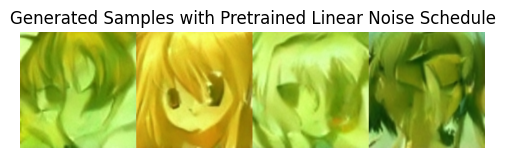

In [21]:
# Generate samples
samples = sample(optim_model, scheduler, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # Scale from [-1, 1] to [0, 1]

# Get current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save each image with timestamp in the filename
for idx, img in enumerate(samples):
    filename = f"images/linear/sample_{timestamp}_{idx+1}.png"
    vutils.save_image(img, filename)

# Visualize the results
grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(6, 3))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated Samples with Pretrained Linear Noise Schedule")
plt.show()

In [22]:
samples_eval = sample(optim_model, scheduler, num_images=200, batch_size=8)

In [23]:
clean_basic()

### Section C: Improved Denoising Schedule ###

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the cosine noise schedule function
def cosine_noise_schedule(timesteps, s=0.008):
    """
    Implements the cosine noise schedule for a DDPM model.
    
    Args:
        timesteps (int): Total number of timesteps in the diffusion process.
        s (float): Small constant to prevent alpha_t from starting at exactly 1.
        
    Returns:
        torch.Tensor: The beta schedule (variance levels) for each timestep.
    """
    # Compute alpha_t_bar (cumulative product of alpha_t values)
    steps = np.linspace(0, timesteps, timesteps + 1, dtype=np.float64)
    alphas_cumprod = np.cos(((steps / timesteps) + s) / (1 + s) * np.pi / 2) ** 2

    # Ensure alphas_cumprod is within [0, 1]
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

    # Compute beta_t from alpha_t_bar
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    
    # Clip beta values to prevent instability
    betas = np.clip(betas, a_min=1e-5, a_max=0.999)

    return torch.tensor(betas, dtype=torch.float32)

# Define timesteps and compute the cosine noise schedule
timesteps = 1000
betas = cosine_noise_schedule(timesteps)

# Initialize the scheduler
cosine_scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")
cosine_scheduler = DDPMScheduler(num_train_timesteps=timesteps, beta_schedule="linear")
cosine_scheduler.betas = betas  # Override betas with the custom cosine schedule
cosine_scheduler.set_timesteps(100)  # Set timesteps for inference (e.g., 100)

In [25]:
# Load the pretrained CelebA DDPM model
pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
cosine_model = pipeline.unet
cosine_model = cosine_model.to(device)  # Move the model to GPU if available

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [26]:
wandb.init(
    project="DDPM_Project",          
    name="experiment_cschedule_256",             
    config={
        "epochs": 5,
        "lr": 1e-4,
        "batch_size": dataloader.batch_size,
        "scheduler": cosine_scheduler.config,
        "model": str(cosine_model.__class__.__name__),
    }
)

In [27]:
# Enable gradient checkpointing for memory savings
cosine_model.enable_gradient_checkpointing()

# Optimizer and scaler for mixed precision
optimizer = Adam(cosine_model.parameters(), lr=wandb.config.lr)
scaler = GradScaler()

cosine_model.train()
num_epochs = wandb.config.epochs
accumulation_steps = 4

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0.0
    epoch_steps = 0
    epoch_step_times = []
    epoch_cuda_alloc = []
    epoch_cuda_reserved = []
    epoch_cpu_mem = []

    optimizer.zero_grad()
    for step, images in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        step_start = time.time()
        images = images.to("cuda").half()  # Ensure input matches FP16
        
        # Sample random timesteps
        batch_size = images.size(0)
        timesteps = torch.randint(0, cosine_scheduler.num_train_timesteps, (batch_size,), device="cuda").long()

        # Generate random noise
        noise = torch.randn_like(images)

        # Add noise to images
        noisy_images = cosine_scheduler.add_noise(images, noise, timesteps)

        # Forward pass with mixed precision
        with autocast():
            noise_pred = cosine_model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        # Normalize loss for gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        # Update weights every `accumulation_steps`
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()


        epoch_loss += loss.item()
        epoch_steps += 1
        epoch_step_times.append(time.time() - step_start)
        epoch_cuda_alloc.append(torch.cuda.memory_allocated() / (1024 ** 2))
        epoch_cuda_reserved.append(torch.cuda.memory_reserved() / (1024 ** 2))
        epoch_cpu_mem.append(psutil.Process().memory_info().rss / (1024 ** 2))


    avg_loss = epoch_loss / epoch_steps
    avg_step_time = sum(epoch_step_times) / epoch_steps
    total_epoch_time = time.time() - epoch_start
    avg_cuda_alloc = sum(epoch_cuda_alloc) / epoch_steps
    avg_cuda_reserved = sum(epoch_cuda_reserved) / epoch_steps
    avg_cpu_mem = sum(epoch_cpu_mem) / epoch_steps

    log_epoch_stats(
        epoch,
        avg_loss,
        avg_step_time,
        total_epoch_time,
        avg_cuda_alloc,
        avg_cuda_reserved,
        avg_cpu_mem
    )

# --- FINISH WANDB RUN ---
wandb.finish()

/var/tmp/ipykernel_664740/823057443.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/5:   0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/var/tmp/ipykernel_664740/823057443.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/5: 100%|██████████| 1000/1000 [07:54<00:00,  2.11it/s]



Epoch 1 Summary:
  Avg Loss:           0.003125
  Avg Step Time:      0.4715 sec
  Total Epoch Time:   474.11 sec
  Avg CUDA Alloc:     3017.51 MB
  Avg CUDA Reserved:  4866.21 MB
  Avg CPU Mem:        2315.55 MB



Epoch 2/5: 100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s]



Epoch 2 Summary:
  Avg Loss:           0.002637
  Avg Step Time:      0.4710 sec
  Total Epoch Time:   473.48 sec
  Avg CUDA Alloc:     3020.15 MB
  Avg CUDA Reserved:  4870.00 MB
  Avg CPU Mem:        2315.55 MB



Epoch 3/5: 100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s]



Epoch 3 Summary:
  Avg Loss:           0.002783
  Avg Step Time:      0.4712 sec
  Total Epoch Time:   473.60 sec
  Avg CUDA Alloc:     3020.15 MB
  Avg CUDA Reserved:  4870.00 MB
  Avg CPU Mem:        2315.55 MB



Epoch 4/5: 100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s]



Epoch 4 Summary:
  Avg Loss:           0.002512
  Avg Step Time:      0.4707 sec
  Total Epoch Time:   473.09 sec
  Avg CUDA Alloc:     3020.15 MB
  Avg CUDA Reserved:  4870.00 MB
  Avg CPU Mem:        2315.55 MB



Epoch 5/5: 100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s]


Epoch 5 Summary:
  Avg Loss:           0.001890
  Avg Step Time:      0.4715 sec
  Total Epoch Time:   473.82 sec
  Avg CUDA Alloc:     3020.15 MB
  Avg CUDA Reserved:  4870.00 MB
  Avg CPU Mem:        2320.64 MB



epoch,▁▃▅▆█
epoch_avg_cpu_mem_MB,▁▁▁▁█
epoch_avg_cuda_alloc_MB,▁████
epoch_avg_cuda_reserved_MB,▁████
epoch_avg_loss,█▅▆▅▁
epoch_avg_step_time_sec,█▃▆▁▇
epoch_total_time_sec,█▄▄▁▆
epoch,5
epoch_avg_cpu_mem_MB,2320.63567
epoch_avg_cuda_alloc_MB,3020.15002
epoch_avg_cuda_reserved_MB,4870


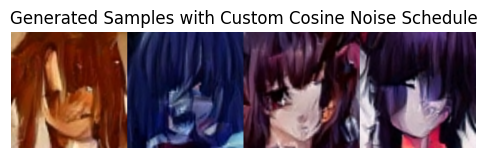

In [28]:
# Generate samples
samples = sample(cosine_model, scheduler, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # Scale from [-1, 1] to [0, 1]

# Get current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save each image with timestamp in the filename
for idx, img in enumerate(samples):
    filename = f"images/cosine/sample_{timestamp}_{idx+1}.png"
    vutils.save_image(img, filename)

# Visualize the results
grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(6, 3))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated Samples with Custom Cosine Noise Schedule")
plt.show()

In [29]:
cosine_samples_eval = sample(cosine_model, cosine_scheduler, num_images=200, batch_size=8)

### Image Evaluation ###

In [30]:
# Collect real images into a tensor
real_images = []
for batch in dataloader:
    real_images.append(batch)  # Assuming `batch` contains images only
real_images = torch.cat(real_images, dim=0)  # Combine into a single tensor

samples_eval = (samples_eval.clamp(-1, 1) + 1) / 2
samples_eval = (samples_eval * 255).clamp(0, 255).to(torch.uint8)

cosine_samples_eval = (cosine_samples_eval.clamp(-1, 1) + 1) / 2
cosine_samples_eval = (cosine_samples_eval * 255).clamp(0, 255).to(torch.uint8)

In [31]:
from torchmetrics.image.fid import FrechetInceptionDistance

# Function to compute FID
def compute_fid(samples1, samples2, device="cuda"):
    """
    Computes the Fréchet Inception Distance (FID) between two sets of samples.
    
    Args:
        samples1 (torch.Tensor): First set of images (e.g., real images) [N, C, H, W].
        samples2 (torch.Tensor): Second set of images (e.g., generated images) [N, C, H, W].
        device (str): Device to run FID computation ("cuda" or "cpu").
    
    Returns:
        float: FID score.
    """
    fid = FrechetInceptionDistance(feature=2048).to(device)
    
    # Update FID with the first set of samples (real images)
    for img in samples1:
        fid.update(img.unsqueeze(0).to(device), real=True)
    
    # Update FID with the second set of samples (generated images)
    for img in samples2:
        fid.update(img.unsqueeze(0).to(device), real=False)
    
    # Compute and return FID
    return fid.compute().item()

In [41]:
no_samples = 200
real_images = (real_images * 255).clamp(0, 255).to(torch.uint8)
fid_default = compute_fid(real_images[:no_samples], samples_eval, device="cuda")
print(f"FID (Linear): {fid_default}")
fid_default = compute_fid(real_images[:no_samples], cosine_samples_eval, device="cuda")
print(f"FID (Cosine): {fid_default}")

FID (Linear): 258.09307861328125
FID (Cosine): 236.69168090820312


In [33]:
from torchmetrics.image.kid import KernelInceptionDistance

def compute_kid(samples1, samples2, device="cuda"):
    """
    Computes the Kernel Inception Distance (KID) between two sets of images.

    Args:
        samples1 (torch.Tensor): First set of images (e.g., real images) [N, C, H, W], values in [0, 1].
        samples2 (torch.Tensor): Second set of images (e.g., generated images) [N, C, H, W], values in [0, 1].
        device (str): Device to run KID computation ("cuda" or "cpu").

    Returns:
        float: KID score (mean over subsets).
        float: KID standard deviation (std over subsets).
    """
    # Ensure both tensors are on the same device
    samples1 = samples1.to(device)
    samples2 = samples2.to(device)
    
    # Initialize KID metric
    kid = KernelInceptionDistance(subset_size=4, feature=2048).to(device)
    
    # Update with real images
    for img in samples1:
        kid.update(img.unsqueeze(0), real=True)
        
    # Update with generated images
    for img in samples2:
        kid.update(img.unsqueeze(0), real=False)
        
    # Compute KID (returns (mean, std))
    kid_mean, kid_std = kid.compute()
    return kid_mean.item(), kid_std.item()

In [42]:
#real_images = (real_images * 255).clamp(0, 255).to(torch.uint8)
fid_default = compute_kid(real_images[:no_samples], samples_eval[:no_samples], device="cuda")
print(f"KID (Linear): {fid_default}")
fid_default = compute_kid(real_images[:no_samples], cosine_samples_eval[:no_samples], device="cuda")
print(f"KID (Cosine): {fid_default}")

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


KID (Linear): (0.21532732248306274, 0.05707784369587898)
KID (Cosine): (0.18930132687091827, 0.041497670114040375)


In [ ]:
import lpips

def get_lp(generated, real):
  loss_fn = lpips.LPIPS(net='vgg')  # Use AlexNet, VGG, or other backbones
  similarity = loss_fn(generated, real)
  return similarity.mean().item()

sample_inception = get_lp(samples_eval[:no_samples], real_images[:no_samples])
cosine_inception = get_lp(cosine_samples_eval[:no_samples], real_images[:no_samples])

print("LP Score Linear Schedule ", sample_inception)
print("LP Score Cosine Scheudle", cosine_inception)


In [36]:
clean_basic()

In [37]:
pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
patch_model = pipeline.unet
patch_model  = patch_model.to(device)  # Move the model to GPU if available

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/yaushingjonathancheung/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


### Section D: Patch-Based Learning ### 

In [38]:
wandb.init(
    project="DDPM_Project",          
    name="experiment_patch_256",             
    config={
        "epochs": 5,
        "lr": 1e-4,
        "batch_size": dataloader.batch_size,
        "scheduler": scheduler.config,
        "model": str(patch_model.__class__.__name__),
    }
)

In [39]:
# Function to extract patches from images
def extract_patches(images, patch_size, stride):
    """
    Extracts patches from a batch of images.

    Args:
        images (torch.Tensor): Tensor of shape (B, C, H, W).
        patch_size (int): Size of each square patch.
        stride (int): Stride between patches.

    Returns:
        patches (torch.Tensor): Tensor of patches with shape (B * num_patches, C, patch_size, patch_size).
        num_patches_per_image (int): Number of patches per image.
    """
    # Unfold the height and width dimensions to create patches
    patches = images.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    # Reshape to (B * num_patches, C, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    num_patches_per_image = patches.size(1) * patches.size(2)  # Number of patches per image
    patches = patches.view(-1, images.size(1), patch_size, patch_size)
    return patches, num_patches_per_image

# Training setup
optimizer = Adam(patch_model.parameters(), lr=1e-4)
patch_model.train()
num_epochs = 5

# Patch parameters
patch_size = 32  # Size of the patches
stride = 32     # Stride between patches (for non-overlapping patches, set stride = patch_size)
mini_batch_size = 16  # Number of patches to process at once

# Create a CUDA stream for asynchronous data transfer
transfer_stream = torch.cuda.Stream()

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss = 0.0
    epoch_steps = 0
    epoch_step_times = []
    epoch_cuda_alloc = []
    epoch_cuda_reserved = []
    epoch_cpu_mem = []
    optimizer.zero_grad()

    for step, images in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        step_start = time.time()
        images = images.to("cpu")  # Keep images on CPU initially to save GPU memory

        # Extract patches from images (on CPU)
        patches, num_patches_per_image = extract_patches(images, patch_size, stride)

        # Initialize placeholders for the next mini-batch
        next_patch_batch = None

        # Process patches in mini-batches
        for patch_start in range(0, patches.size(0), mini_batch_size):
            # Transfer the next mini-batch of patches to GPU asynchronously
            if next_patch_batch is None:
                # For the first iteration, load the current mini-batch directly
                patch_batch = patches[patch_start:patch_start + mini_batch_size].to("cuda", non_blocking=True)
            else:
                # Use the preloaded batch from the previous iteration
                patch_batch = next_patch_batch

            # Preload the next mini-batch while the current one is being processed
            next_patch_start = patch_start + mini_batch_size
            if next_patch_start < patches.size(0):
                with torch.cuda.stream(transfer_stream):
                    next_patch_batch = patches[next_patch_start:next_patch_start + mini_batch_size].to(
                        "cuda", non_blocking=True
                    )

            # Sample random timesteps for diffusion
            batch_size = patch_batch.size(0)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (batch_size,), device="cuda").long()
            noise = torch.randn_like(patch_batch)

            # Add noise to patches
            noisy_patches = scheduler.add_noise(patch_batch, noise, timesteps)

            # Forward pass
            noise_pred = patch_model(noisy_patches, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Synchronize the transfer stream with the default stream
            torch.cuda.synchronize()

            # Record stats
            epoch_loss += loss.item()
            epoch_steps += 1

        # Record memory usage stats after processing all patches for this batch
        epoch_step_times.append(time.time() - step_start)
        epoch_cuda_alloc.append(torch.cuda.memory_allocated() / (1024 ** 2))
        epoch_cuda_reserved.append(torch.cuda.memory_reserved() / (1024 ** 2))
        epoch_cpu_mem.append(psutil.Process().memory_info().rss / (1024 ** 2))

    # Calculate and log epoch statistics
    avg_loss = epoch_loss / epoch_steps
    avg_step_time = sum(epoch_step_times) / epoch_steps
    total_epoch_time = time.time() - epoch_start
    avg_cuda_alloc = sum(epoch_cuda_alloc) / epoch_steps
    avg_cuda_reserved = sum(epoch_cuda_reserved) / epoch_steps
    avg_cpu_mem = sum(epoch_cpu_mem) / epoch_steps

    log_epoch_stats(
        epoch,
        avg_loss,
        avg_step_time,
        total_epoch_time,
        avg_cuda_alloc,
        avg_cuda_reserved,
        avg_cpu_mem
    )

# Finish training
wandb.finish()

Epoch 1/5:   0%|          | 0/1000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/5: 100%|██████████| 1000/1000 [21:41<00:00,  1.30s/it]



Epoch 1 Summary:
  Avg Loss:           0.010786
  Avg Step Time:      0.1624 sec
  Total Epoch Time:   1301.12 sec
  Avg CUDA Alloc:     444.71 MB
  Avg CUDA Reserved:  533.75 MB
  Avg CPU Mem:        599.41 MB



Epoch 2/5: 100%|██████████| 1000/1000 [23:33<00:00,  1.41s/it]



Epoch 2 Summary:
  Avg Loss:           0.009834
  Avg Step Time:      0.1764 sec
  Total Epoch Time:   1413.67 sec
  Avg CUDA Alloc:     444.61 MB
  Avg CUDA Reserved:  533.75 MB
  Avg CPU Mem:        600.08 MB



Epoch 3/5: 100%|██████████| 1000/1000 [39:33<00:00,  2.37s/it]



Epoch 3 Summary:
  Avg Loss:           0.009369
  Avg Step Time:      0.2964 sec
  Total Epoch Time:   2373.73 sec
  Avg CUDA Alloc:     444.61 MB
  Avg CUDA Reserved:  533.75 MB
  Avg CPU Mem:        601.66 MB



Epoch 4/5: 100%|██████████| 1000/1000 [29:20<00:00,  1.76s/it]



Epoch 4 Summary:
  Avg Loss:           0.009152
  Avg Step Time:      0.2197 sec
  Total Epoch Time:   1760.19 sec
  Avg CUDA Alloc:     444.61 MB
  Avg CUDA Reserved:  533.75 MB
  Avg CPU Mem:        601.66 MB



Epoch 5/5: 100%|██████████| 1000/1000 [26:26<00:00,  1.59s/it]


Epoch 5 Summary:
  Avg Loss:           0.009088
  Avg Step Time:      0.1980 sec
  Total Epoch Time:   1586.18 sec
  Avg CUDA Alloc:     444.61 MB
  Avg CUDA Reserved:  533.75 MB
  Avg CPU Mem:        601.66 MB



epoch,▁▃▅▆█
epoch_avg_cpu_mem_MB,▁▃███
epoch_avg_cuda_alloc_MB,█▁▁▁▁
epoch_avg_cuda_reserved_MB,▁████
epoch_avg_loss,█▄▂▁▁
epoch_avg_step_time_sec,▁▂█▄▃
epoch_total_time_sec,▁▂█▄▃
epoch,5
epoch_avg_cpu_mem_MB,601.66162
epoch_avg_cuda_alloc_MB,444.60833
epoch_avg_cuda_reserved_MB,533.75
